In [226]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from torchvision import transforms
from scipy import linalg
import warnings


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
  )
)

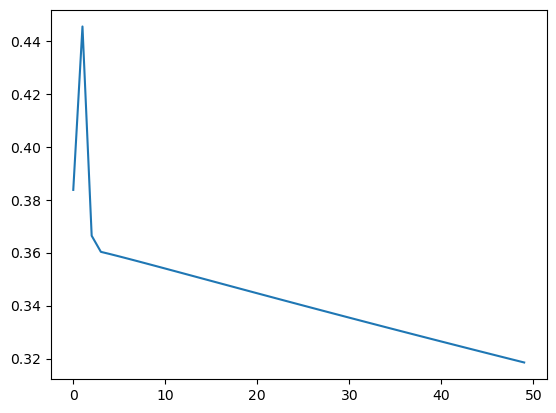

In [228]:
numSamples = 57
EPOCHS = 50
loss_func = nn.L1Loss()

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(4096,128), nn.ReLU(True), nn.Dropout())
        self.decoder = nn.Sequential(nn.Linear(128,4096))
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

ae = AutoEncoder().cuda()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
data = data.reshape(data.shape[0], -1)[:numSamples]
losses = []

for epoch in range(EPOCHS):   
    x = torch.autograd.Variable(data[torch.randperm(numSamples)]).cuda()
    optimizer.zero_grad()
    pred = ae(x)
    loss = loss_func(pred, x)
    losses.append(loss.cpu().data.item())
    loss.backward()
    optimizer.step()
plt.plot(losses)

ae.eval()

In [229]:
def FID(mu1, mu2, sigma1, sigma2): 
    eps=1e-30
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

# def calcFID(data):
#     data = data.reshape(data.shape[0], -1)
#     features = ae.encoder(data.cuda()).detach().cpu().numpy()
#     mean, covar = np.mean(features, 0), np.cov(features, rowvar=False)
#     return FID(mean, base_mean, covar, base_covar)

In [230]:
data = torch.load('../data/test.pt')
data2 =  torch.load('../data/ExGAN0.005.pt')

data = data.reshape(data.shape[0], -1)
features = ae.encoder(data.cuda()).detach().cpu().numpy()
mean, covar = np.mean(features, 0), np.cov(features, rowvar=False)
data2 = data2.reshape(data2.shape[0], -1)
base_features = ae.encoder(Variable(data2).cuda()).detach().cpu().numpy()
base_mean, base_covar = np.mean(base_features, 0), np.cov(base_features, rowvar=False)
FID(mean, base_mean, covar, base_covar)

C:\Users\mfy\AppData\Local\Temp\ipykernel_9128\3727952237.py:17: UserWarning: fid calculation produces singular product; adding 1e-30 to diagonal of cov estimates
  warnings.warn(msg)


2.376188838787603